In [ ]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

from GPUtil import showUtilization as gpu_usage
gpu_usage()                             


In [ ]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


import torch
import gc
# from GPUtil import showUtilization as gpu_usage


## shared code

In [30]:
# essential functions 
def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [31]:
# extract the main info from the label into three columns 

def write_break_down_columns(old_caption_file, new_caption_file):
    with open(old_caption_file, 'r') as f:
        for line in f:
            # skip title
            if 'image,caption,psum,psum_sq' in line:
                continue

            image_name, text_label,psum,psum_sq = line.split(',')
            text_label = text_label.strip()

            struc_label = Caption(text_label, support_plural=True).get_structured()
            shield_color = struc_label['shield']['color']
            first_object = struc_label['objects'][0]
            mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
            write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{shield_color},{psum},{psum_sq}")


In [32]:
# write back the class number to the annotiation file
def get_image_class(item, classes_map):
    for k,v in classes_map.items():
        if v == item:
            return k
    return None
    
def write_class_colum(df, with_class_caption_file, classes_map):
    for _,line in df.iterrows():
        image_name,charge,mod,color,shield_color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['shield_color'],line['psum'],line['psum_sq']
        image_class = get_image_class((charge, mod, color, shield_color),classes_map)

        write_line_to_file(with_class_caption_file, f"{image_name},{charge},{mod},{color},{shield_color},{psum},{psum_sq},{image_class}")


In [33]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")
#         print(img)
        # apply the transfromation to the image
        if self.transform is not None:
#             print('self.transform is not None')
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)
#         print('img_t: ',img_t)

        return img_t

    def _get_label_class(self, idx):
        
        label_class = self.classes[idx]
#         print('label_class',label_class)
        
#         if self.transform is not None:
#             label_class_t = self.transform(label_class)
#         else:
#             trans = T.ToTensor()
#             label_class_t = trans(label_class)

        return label_class

    



In [34]:
def visualize_one_batch(data_loader):
    # Visualize one training batch
    for images,classes,_,_,_ in data_loader:
        print(classes)
        fig, ax = plt.subplots(figsize = (25, 25))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 3).permute(1,2,0))
        break


In [35]:
def calc_accuracy(true, pred):
    accuracies = []
    accuracies_charge_only = []
    accuracies_charge_color = []
    accuracies_shield_only = []

    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    batch_size = len(pred)
    
    pred_t, true_t = pred.argmax(-1), true.argmax(-1)
    for i in range(0, batch_size-1):
        score, charge_score, charge_color_score, shield_color_score = calc_predicted_label_accuracy(true_t[i], pred_t[i])
        accuracies.append(score)
        accuracies_charge_only.append(charge_score)
        accuracies_charge_color.append(charge_color_score)
        accuracies_shield_only.append(shield_color_score)
        
#     acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
#     acc = float((100 * acc.sum()) / len(acc))
#     print(f"--------------------")
    
#     return round(acc, 4)
    return accuracies, accuracies_charge_only, accuracies_charge_color, accuracies_shield_only

def calc_accuracy_standard(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [36]:
# def get_labels_of_batch(batch):
#     outputs = batch.argmax(1)
#     print(outputs)
#     labels = []
#     for out in outputs:
#         print('class / label:', out, CLASSES_MAP.get(int(out)))
#         labels.append(CLASSES_MAP.get(out))
#     return labels

def calc_predicted_label_accuracy(true_class, predicted_class):
    
    true_label = CLASSES_MAP.get(int(true_class))

    charge = true_label[0]
    modifier = true_label[1]
    charge_color = true_label[2]
    shield_color = true_label[3]

    predicted_label = CLASSES_MAP.get(int(predicted_class))

    pre_charge = predicted_label[0]
    pre_modifier = predicted_label[1]
    pre_charge_color = predicted_label[2]
    pre_shield_color = predicted_label[3]
    
    charge_hits = 0
    modifier_hits = 0
    charge_color_score = 0
    shield_color_score = 0
    
    if charge == pre_charge:
        charge_hits+=1
    
    if modifier == pre_modifier:
        modifier_hits+=1

    if charge_color == pre_charge_color:
        charge_color_score+=1
        
    if shield_color == pre_shield_color:
        shield_color_score+=1

    charge_score = (charge_hits + modifier_hits) / 2
    
    score = (charge_score + charge_color_score + shield_color_score) / 3
    
    return score, charge_score, charge_color_score, shield_color_score
    
    

In [166]:
### Training Code
from src.pytorchtools import EarlyStopping, EarlyStoppingAccuracy

def train_classification_model(model, optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device):
    from tqdm import tqdm
    
    # initialize the early_stopping object
    checkpoint_file=f"{data_location}/classification-checkpoint.pt"
    early_stopping = EarlyStoppingAccuracy(patience=10, verbose=True, path=checkpoint_file)

    accuracies = []
    accuracies_charge_only = []
    accuracies_charge_color = []
    accuracies_shield_only = []

    avg_acc_ls = []
    avg_acc_ls_charge_only = []
    avg_acc_ls_charge_color = []
    avg_acc_ls_shield_only = []

    avg_train_acc_list = []
    for epoch in range(epochs):
        start = time.time()

        #Epoch Loss & Accuracy
        train_epoch_losses = []
        train_epoch_accuracies = []
        _iter = 1

        #Val Loss & Accuracy
        val_epoch_losses = []
        val_epoch_accuracies = []
        train_epoch_accuracies = []
        train_epoch_losses = []
        # Training
        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
            for images, labels,_,_,_ in tepoch: 
                images = images.to(device)
                labels = labels.to(device)

                #Reset Grads
                optimizer.zero_grad()

                #Forward ->
                preds = model(images)

#                 #Calculate Accuracy
#                 print("train_classification_model")
                acc = calc_accuracy_standard(labels.cpu(), preds.cpu())
#                 print("-----------------------------------")

                #Calculate Loss & Backward, Update Weights (Step)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
#                 lr_scheduler.step()
                
                #Append loss & acc
                loss_value = loss.item()
                train_epoch_losses.append(loss_value)
                train_epoch_accuracies.append(acc)
                
                tepoch.set_postfix({'train_batch_loss': loss_value})
                tepoch.set_postfix({'train_batch_accuracy': acc})

                if _iter % 500 == 0:
                    print("> Iteration {} < ".format(_iter))
                    print("Iter Loss = {}".format(round(loss_value, 4)))
                    print("Iter Accuracy = {} % \n".format(acc))

                _iter += 1
                
        
        train_epoch_loss = sum(train_epoch_losses) / len(train_epoch_losses)
        train_epoch_accuracy = sum(train_epoch_accuracies) / len(train_epoch_accuracies)
        tepoch.set_postfix({'train_epoch_loss': train_epoch_loss})
        tepoch.set_postfix({'train_epoch_accuracy': train_epoch_accuracy})

        avg_train_acc_list.append(train_epoch_accuracy)

        # tryinf to free the memory
#         gc.collect()
#         torch.cuda.empty_cache()
#         gpu_usage()                             

        #Validation
        with tqdm(val_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for images, labels,_,_,images_names in tepoch:
                images = images.to(device)
                labels = labels.to(device)

                #Forward ->
                preds = model(images)

                #Calculate Accuracy
#                 print("evaluation_classification")
#                 print('images_names', images_names)
                
                acc1, acc2, acc3, acc4 = calc_accuracy(labels.cpu(), preds.cpu())
                for i in acc1:
                    accuracies.append(i)
                for i in acc2:
                    accuracies_charge_only.append(i)
                for i in acc3:
                    accuracies_charge_color.append(i)
                for i in acc4:
                    accuracies_shield_only.append(i)

                print("-----------------------------------")

                #Calculate Loss
                loss = criterion(preds, labels)

                #Append loss & acc
                loss_value = loss.item()
                tepoch.set_postfix({'val_epoch_loss': loss_value})
                val_epoch_losses.append(loss_value)

        # ------------------------------------------
        # calc avg values coming out of every batch in one epoch 
        val_epoch_accuracy = sum(accuracies) / len(accuracies)
        
        # breakdown of accuracies - average per validation
        avg_acc_charge_only  = sum(accuracies_charge_only) / len(accuracies_charge_only)
        avg_acc_charge_color = sum(accuracies_charge_color) / len(accuracies_charge_color)
        avg_acc_shield_only  = sum(accuracies_shield_only) / len(accuracies_shield_only)
       
        val_epoch_accuracies.append(val_epoch_accuracy)
        tepoch.set_postfix({'val_epoch_accuracy': val_epoch_accuracy})
        # ------------------------------------------

        train_epoch_loss = np.mean(train_epoch_losses)
        val_epoch_loss = np.mean(val_epoch_losses)
        
        # collect avg loss values coming out of every batch in one epoch
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)

        # ------------------------------------------  
        # collect avg values coming out of every epochs 
        avg_acc_ls.append(val_epoch_accuracy)
        avg_acc_ls_charge_only.append(avg_acc_charge_only)
        avg_acc_ls_charge_color.append(avg_acc_charge_color)
        avg_acc_ls_shield_only.append(avg_acc_shield_only)
        # ------------------------------------------
        end = time.time()

        # Print Epoch Statistics
        print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
        print("Train Loss = {}".format(round(train_epoch_loss, 4)))
        print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
        print("Val Loss = {}".format(round(val_epoch_loss, 4)))
        print("Val epoch Accuracy = {} % \n".format(val_epoch_accuracy))
        print("Val Charge Accuracy = {} % \n".format(avg_acc_charge_only))
        print("Val Charge Color Accuracy = {} %\n".format(avg_acc_charge_color))
        print("Val Shield Color Accuracy = {} % \n".format(avg_acc_shield_only))
        
        early_stopping(val_epoch_accuracy, model, optimizer, epoch)
           
        if early_stopping.early_stop:
            print("Early stopping. Stopping the training of the model.")
            break
        print("------------------------------------------------------------")

    val_acc_score = sum(avg_acc_ls) / len(avg_acc_ls)
    acc_score_charge = sum(avg_acc_ls_charge_only) / len(avg_acc_ls_charge_only)
    acc_score_charge_color = sum(avg_acc_ls_charge_color) / len(avg_acc_ls_charge_color)
    acc_score_shield = sum(avg_acc_ls_shield_only) / len(avg_acc_ls_shield_only)
    ftrain_loss = sum(train_loss) / len(train_loss) 
    fval_loss = sum(val_loss) / len(val_loss) 
    train_acc_standard = sum(avg_train_acc_list) / len(avg_train_acc_list) 
    
    print('Final Accuracy ALL (Overall): {}%'.format(100. * round(val_acc_score, 2)))
    print('Final Accuracy Charge-Mod only (Overall): {}%'.format(100. * round(acc_score_charge, 2)))
    print('Final Accuracy Charge color (Overall): {}%'.format(100. * round(acc_score_charge_color, 2)))
    print('Final Accuracy Shield color (Overall): {}%'.format(100. * round(acc_score_shield, 2)))
    print('Final train loss (Overall): {}'.format(round(ftrain_loss, 2)))
    print('Final val loss (Overall): {}'.format(round(fval_loss, 2)))
            
    return model, ftrain_loss, train_acc_standard, fval_loss, val_acc_score




In [155]:
def test_classification_model(model, test_data_loader):
    test_epoch_loss = []
    test_epoch_accuracy = []

    test_loss = []
    test_accuracy = []

    accuracies = []
    accuracies_charge_only = []
    accuracies_charge_color = []
    accuracies_shield_only = []

    accuracy_test_list = []
    accuracy_test_list_charge=[]
    accuracy_test_list_charge_color=[]
    accuracy_test_list_shield=[]

    # model.eval()
    with torch.no_grad():
        for images, labels,_,_,_ in test_data_loader:
            print(type(labels))
            images = images.to("cpu")
            labels = labels.to("cpu")

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy_standard(labels.cpu(), preds.cpu())
            acc1,acc2,acc3,acc4 = calc_accuracy(labels.cpu(), preds.cpu())
            for i in acc1:
                accuracies.append(i)
            for i in acc2:
                accuracies_charge_only.append(i)
            for i in acc3:
                accuracies_charge_color.append(i)
            for i in acc4:
                accuracies_shield_only.append(i)

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            test_epoch_loss.append(loss_value)
            test_epoch_accuracy.append(acc)

            avg_batch_acc = sum(accuracies)/len(accuracies)
            avg_batch_acc_charge = sum(accuracies_charge_only)/len(accuracies_charge_only)
            avg_batch_acc_chrage_color = sum(accuracies_charge_color)/len(accuracies_charge_color)
            avg_batch_acc_shield = sum(accuracies_shield_only)/len(accuracies_shield_only)
            
#             avg_batch_acc_charge, avg_batch_acc_chrage_color, avg_batch_acc_shield = 0,0,0
            accuracy_test_list.append(avg_batch_acc)
            accuracy_test_list_charge.append(avg_batch_acc_charge)
            accuracy_test_list_charge_color.append(avg_batch_acc_chrage_color)
            accuracy_test_list_shield.append(avg_batch_acc_shield)
            
            print("Test Accuracy Standard (in progress) = {} % \n".format(acc))
            print('Test Accuracy ALL (in progress): {}%'.format(100. * round(avg_batch_acc, 2)))
            print('Test Accuracy Charge-Mod only (in progress): {}%'.format(100. * round(avg_batch_acc_charge, 2)))
            print('Test Accuracy Charge color (in progress): {}%'.format(100. * round(avg_batch_acc_chrage_color, 2)))
            print('Test Accuracy Shield color (in progress): {}%'.format(100. * round(avg_batch_acc_shield, 2)))
            
    test_epoch_loss = sum(test_epoch_loss) / len(test_epoch_loss)
    test_epoch_accuracy =  sum(test_epoch_accuracy) / len(test_epoch_accuracy)

    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print("Final Test Loss = {}".format(round(test_epoch_loss, 4)))
    print("Test Accuracy Standard = {} % \n".format(test_epoch_accuracy))

    acc_test_score = sum(accuracy_test_list) / len(accuracy_test_list)
    acc_test_score_charge = sum(accuracy_test_list_charge) / len(accuracy_test_list_charge)
    acc_test_score_charge_color = sum(accuracy_test_list_charge_color) / len(accuracy_test_list_charge_color)
    acc_test_score_shield = sum(accuracy_test_list_shield) / len(accuracy_test_list_shield)
    
    print('Final Test Accuracy ALL (Overall): {}%'.format(100. * round(acc_test_score, 2)))
    print('Final Test Accuracy Charge-Mod only (Overall): {}%'.format(100. * round(acc_test_score_charge, 2)))
    print('Final Test Accuracy Charge color (Overall): {}%'.format(100. * round(acc_test_score_charge_color, 2)))
    print('Final Test Accuracy Shield color (Overall): {}%'.format(100. * round(acc_test_score_shield, 2)))


# Train on dataset with single object

## Data preprocessing 

In [111]:

MISSING_TOKEN = 'None'

In [112]:
# data_location =  '../baseline-gen-data/small/'
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'
caption_file = data_location + 'test_real_captions_psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq-2.txt'




In [113]:
# creat_caption_file(new_caption_file, 'image,charge,mod,color,shield_color,psum,psum_sq')


In [114]:
# write_break_down_columns(caption_file, new_caption_file)

In [115]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,shield_color,psum,psum_sq
0,6423_G A cross.jpg,cross,None,A,G,795074.312500,609741.125000
1,1739_A G cross patonce.jpg,cross,patonce,G,A,719996.687500,553701.875000
2,2870_O S lion rampant.jpg,lion,rampant,S,O,370225.062500,231052.937500
3,18746_S A eagle.jpg,eagle,None,A,S,545993.937500,372998.000000
4,4660_G O eagle.jpg,eagle,None,O,G,20764.722656,12016.292969
...,...,...,...,...,...,...,...
145,6679_O S eagle.jpg,eagle,None,S,O,565107.125000,409840.343750
146,29394_G O eagle doubleheaded.jpg,eagle,doubleheaded,O,G,617640.000000,469392.843750
147,398_A S lion rampant.jpg,lion,rampant,S,A,673486.000000,517662.500000
148,4459_B O eagle.jpg,eagle,None,O,B,621506.687500,425807.562500


In [116]:
# Getting classes
column_values = df[['charge','mod', 'color', 'shield_color']].value_counts(dropna=False)
column_values

charge  mod           color  shield_color
lion    rampant       O      G               9
                      G      A               6
eagle   None          S      O               6
lion    rampant       G      O               6
                      B      O               6
                                            ..
eagle   doubleheaded  A      S               1
        None          G      B               1
cross   moline        B      O               1
eagle   None          G      O               1
lion    passt guard   O      G               1
Length: 63, dtype: int64

In [117]:
classes = list(column_values.to_dict().keys())
classes

[('lion', 'rampant', 'O', 'G'),
 ('lion', 'rampant', 'G', 'A'),
 ('eagle', 'None', 'S', 'O'),
 ('lion', 'rampant', 'G', 'O'),
 ('lion', 'rampant', 'B', 'O'),
 ('lion', 'rampant', 'A', 'B'),
 ('lion', 'rampant', 'S', 'O'),
 ('lion', 'rampant', 'S', 'A'),
 ('eagle', 'None', 'O', 'B'),
 ('cross', 'moline', 'G', 'A'),
 ('eagle', 'doubleheaded', 'S', 'O'),
 ('eagle', 'None', 'O', 'G'),
 ('eagle', 'None', 'A', 'G'),
 ('cross', 'None', 'G', 'O'),
 ('lion', 'rampant', 'A', 'G'),
 ('lion', 'rampant', 'B', 'A'),
 ('lion', 'rampant', 'O', 'B'),
 ('lion', 'rampant', 'O', 'S'),
 ('eagle', 'None', 'G', 'A'),
 ('cross', 'None', 'A', 'B'),
 ('cross', 'None', 'G', 'A'),
 ('cross', 'None', 'S', 'A'),
 ('cross', 'None', 'S', 'O'),
 ('cross', 'moline', 'S', 'O'),
 ('cross', 'None', 'A', 'G'),
 ('cross', 'None', 'A', 'V'),
 ('lion', 'None', 'S', 'O'),
 ('eagle', 'doubleheaded', 'G', 'A'),
 ('eagle', 'doubleheaded', 'A', 'G'),
 ('eagle', 'None', 'S', 'A'),
 ('eagle', 'None', 'O', 'V'),
 ('eagle', 'doublehea

In [118]:
len(classes)

63

In [119]:
type(classes[0])

tuple

In [120]:
# Give unique number to each class, , easier than handeling an enum of three strings!

CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('lion', 'rampant', 'O', 'G'),
 1: ('lion', 'rampant', 'G', 'A'),
 2: ('eagle', 'None', 'S', 'O'),
 3: ('lion', 'rampant', 'G', 'O'),
 4: ('lion', 'rampant', 'B', 'O'),
 5: ('lion', 'rampant', 'A', 'B'),
 6: ('lion', 'rampant', 'S', 'O'),
 7: ('lion', 'rampant', 'S', 'A'),
 8: ('eagle', 'None', 'O', 'B'),
 9: ('cross', 'moline', 'G', 'A'),
 10: ('eagle', 'doubleheaded', 'S', 'O'),
 11: ('eagle', 'None', 'O', 'G'),
 12: ('eagle', 'None', 'A', 'G'),
 13: ('cross', 'None', 'G', 'O'),
 14: ('lion', 'rampant', 'A', 'G'),
 15: ('lion', 'rampant', 'B', 'A'),
 16: ('lion', 'rampant', 'O', 'B'),
 17: ('lion', 'rampant', 'O', 'S'),
 18: ('eagle', 'None', 'G', 'A'),
 19: ('cross', 'None', 'A', 'B'),
 20: ('cross', 'None', 'G', 'A'),
 21: ('cross', 'None', 'S', 'A'),
 22: ('cross', 'None', 'S', 'O'),
 23: ('cross', 'moline', 'S', 'O'),
 24: ('cross', 'None', 'A', 'G'),
 25: ('cross', 'None', 'A', 'V'),
 26: ('lion', 'None', 'S', 'O'),
 27: ('eagle', 'doubleheaded', 'G', 'A'),
 28: ('eagle', 'd

In [121]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62])

In [122]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq-2.txt'


In [123]:
# creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,shield_color,psum,psum_sq,class')


In [124]:
# write_class_colum(df, new_with_class_caption_file, CLASSES_MAP)
    

In [125]:
df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,shield_color,psum,psum_sq,class
0,6423_G A cross.jpg,cross,None,A,G,795074.312500,609741.125000,24
1,1739_A G cross patonce.jpg,cross,patonce,G,A,719996.687500,553701.875000,36
2,2870_O S lion rampant.jpg,lion,rampant,S,O,370225.062500,231052.937500,6
3,18746_S A eagle.jpg,eagle,None,A,S,545993.937500,372998.000000,33
4,4660_G O eagle.jpg,eagle,None,O,G,20764.722656,12016.292969,11
...,...,...,...,...,...,...,...,...
145,6679_O S eagle.jpg,eagle,None,S,O,565107.125000,409840.343750,2
146,29394_G O eagle doubleheaded.jpg,eagle,doubleheaded,O,G,617640.000000,469392.843750,31
147,398_A S lion rampant.jpg,lion,rampant,S,A,673486.000000,517662.500000,7
148,4459_B O eagle.jpg,eagle,None,O,B,621506.687500,425807.562500,8


In [126]:
# train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq-2.txt'
val_annotation_file  = data_location + '/val_labels_psumsq-2.txt'
test_annotation_file  = data_location + '/test_labels_psumsq-2.txt'

# train.to_csv(train_annotation_file, sep=',',index=False)
# test.to_csv(test_annotation_file, sep=',',index=False)
# validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))


There are 90 train images
There are 30 val images
There are 30 test images


## what are the classes that the model saw during training and then testing/validation?

In [127]:

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


In [128]:
df1_classes = list(df1['class'])
df2_classes = list(df2['class'])
df3_classes = list(df3['class'])

In [129]:
# train and validation
intersection(df1_classes, df2_classes)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 21, 25]

In [130]:
# train and test
intersection(df1_classes, df3_classes)

[0, 1, 2, 4, 6, 9, 11, 14, 16, 18, 23, 26]

In [131]:
set(df3_classes)

{0, 1, 2, 4, 6, 9, 11, 14, 16, 18, 20, 23, 24, 26, 41, 48, 50, 52, 54, 55, 59}

In [132]:
# classes in test which the model didn't see during training 
list(set(df3_classes) - set(intersection(df1_classes, df2_classes)))

[41, 11, 14, 16, 48, 18, 50, 20, 52, 54, 23, 24, 55, 26, 59]

In [133]:
list(set(df1_classes))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 42,
 43,
 46,
 49,
 56,
 57,
 58,
 61,
 62]

In [134]:
# number of items/classes in test 
len(df3_classes)

30

In [135]:
# number of unique calsses in test
len(list(set(df3_classes)))

21

# Dataset and Dataloader  

In [136]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [137]:
BATCH_SIZE = 3
NUM_WORKER = 2 #### this needs multi-core
# NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [138]:
images_location = data_location + '/resized'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [139]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(3, 0)), tensor([], size=(3, 0)))

In [140]:
mean = get_mean(train_dataset, train_data_loader, 621 , 634)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [141]:
std = get_std(train_dataset, train_data_loader, mean, 621 , 634)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


In [142]:
mean, std

(tensor(0.5162, dtype=torch.float64), tensor(0.3284, dtype=torch.float64))

# Dataset and Dataloader  

In [143]:
# transform = T.Compose([
#     T.Resize(226),                     
#     T.RandomCrop(224),                 
#     T.ToTensor(),                               
#     T.Normalize(mean, std)
# ])
import random
from src.baseline.noise import Noise
import torchvision.transforms as T
height, width = 621 , 634

train_transform_list = [
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomCrop(224),
#         T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#         T.ColorJitter(brightness=.5, hue=.3)
]

# Use RandomApply to apply the transform randomly to some of the images
transform_with_random = T.Compose([
    T.Resize((height, width)), # mandetory                  
#         T.RandomApply(transforms=train_transform_list, p=0.8),
    random.choice(train_transform_list),
    T.ToTensor(),
    T.Normalize(mean, std), # mandetory 
    Noise(0.1, 0.05), # this should come at the end
])

In [144]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform_with_random, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform_with_random, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform_with_random, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/salnabulsi/coat-of-arms/data/new//resized, transform=Compose(
     Resize(size=(621, 634), interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.5161571236990756, std=0.32835697916343526)
     Noise(mean=0.1,stddev=0.05)
 ), device=cuda:0, df=                               image charge           mod color shield_color  \
 0          1335_G A lion rampant.jpg   lion       rampant     A            G   
 1   29394_G O eagle doubleheaded.jpg  eagle  doubleheaded     O            G   
 2                 5401_B O eagle.jpg  eagle          None     O            B   
 3           715_O S lion rampant.jpg   lion       rampant     S            O   
 4                 5855_O S cross.jpg  cross          None     S            O   
 ..                               ...    ...           ...   ...          ...   
 85          398_A S lion rampant.jpg   lion       rampant     S

In [145]:
# Data Loader  -  using Sampler (YT Video)

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([39,  3, 43])


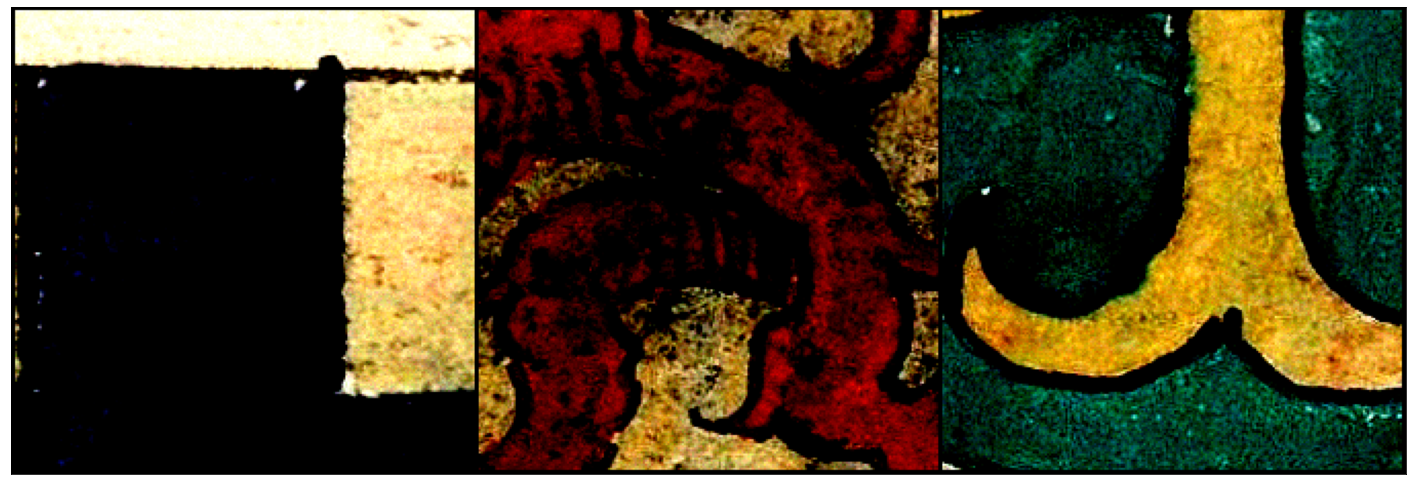

In [172]:
visualize_one_batch(train_data_loader)

Caption: 9961_O G lion rampant.jpg lion rampant G
(604, 614, 3)


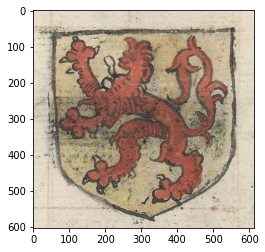

In [147]:
import matplotlib.image as mpimg
i = 8
image_path = images_location +'/'+ df1.iloc[i,0]
print("Caption:", df1.iloc[i,0], df1.iloc[i,1], df.iloc[i,2],df1.iloc[i,3])
img=mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


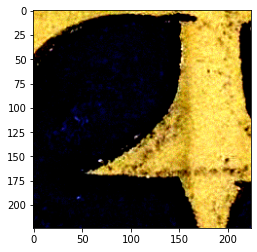

In [148]:
dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
img = images[0]
# print(img)
# img=mpimg.imread(image_path)
print(img.shape)
# plt.imshow(img)
plt.imshow(img.permute(1,2,0))
plt.show()


In [149]:
# visualize_one_batch(val_data_loader)

# Model Definition

In [150]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)


In [151]:

# from torchviz import make_dot, make_dot_from_trace

# make_dot(model, params=dict(model.named_parameters()))


# Model Training, Validation and Testing lr = 0.0009

In [152]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 100
CUDA_LAUNCH_BLOCKING=1


In [163]:

model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)


Epoch 0:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-0 lr: 0.0009


Epoch 0:  40%|██████████▍               | 4/10 [00:01<00:01,  4.87batch/s, val_epoch_loss=4.77]

evaluation_classification
images_names ('7037_A G cross.jpg', '3551_G A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '6178_A G eagle doubleheaded.jpg', '29743_O A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '7788_S A cross.jpg', '2870_O S lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '5096_B O lion.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '255_O V cross.jpg', '23292_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6384_A G cross moline.jpg', '3783_A S cross.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '297

Epoch 0: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.76batch/s, val_epoch_loss=5.67]


evaluation_classification
images_names ('6736_O B lion rampant.jpg', '18847_B A eagle.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '4289_V A lion rampant.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '5302_O B cross moline.jpg', '2712_G A eagle.jpg')
-----------------------------------
** Epoch 0 ** - Epoch Time 3
Train Loss = 3.9522
Train Accuracy = 2.22222 % 

Val Loss = 5.2161
Val epoch Accuracy = 0.175 % 

Val Charge Accuracy = 0.175 % 

Val Charge Color Accuracy = 0.15 % 

Val Shield Color Accuracy = 0.2 % 

Accuracy increased (0.000000 --> 0.175000).  Saving model ...
------------------------------------------------------------


Epoch 1:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-1 lr: 0.0009


Epoch 1:  40%|██████████▍               | 4/10 [00:01<00:01,  4.76batch/s, val_epoch_loss=6.94]

evaluation_classification
images_names ('6587_G A eagle.jpg', '5302_O B cross moline.jpg', '4289_V A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('3551_G A eagle.jpg', '4150_A G eagle doubleheaded.jpg', '2870_O S lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('29733_O G cross.jpg', '-1_G O lion rampant.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('3783_A S cross.jpg', '6384_A G cross moline.jpg', '6679_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '18847_B A eagle.jpg', '255_O V cross.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '23292_O S eagle.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('29743_O A eagle.jpg', '1537_A S eagle 

Epoch 1: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.60batch/s, val_epoch_loss=8.98]

evaluation_classification
images_names ('2712_G A eagle.jpg', '18863_B A lion rampant.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '6178_A G eagle doubleheaded.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '7037_A G cross.jpg', '7788_S A cross.jpg')
-----------------------------------
** Epoch 1 ** - Epoch Time 3
Train Loss = 3.9192
Train Accuracy = 6.666660000000001 % 

Val Loss = 6.1626
Val epoch Accuracy = 0.20833333333333331 % 

Val Charge Accuracy = 0.15 % 

Val Charge Color Accuracy = 0.225 % 

Val Shield Color Accuracy = 0.25 % 

Accuracy increased (0.175000 --> 0.208333).  Saving model ...


------------------------------------------------------------


Epoch 2:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0009


Epoch 2:  40%|██████████▍               | 4/10 [00:01<00:01,  4.77batch/s, val_epoch_loss=7.22]

evaluation_classification
images_names ('5096_B O lion.jpg', '-1_G O lion rampant.jpg', '2870_O S lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '29743_O A eagle.jpg', '1537_A S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6679_O S eagle.jpg', '18825_O S eagle doubleheaded.jpg', '7788_S A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('2712_G A eagle.jpg', '3783_A S cross.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '6736_O B lion rampant.jpg', '18847_B A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '3551_G A eagle.jpg', '23292_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '6178_A G eagle 

Epoch 2: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.57batch/s, val_epoch_loss=4.93]


evaluation_classification
images_names ('6150_A G cross.jpg', '29733_O G cross.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '4289_V A lion rampant.jpg', '6384_A G cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '7037_A G cross.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
** Epoch 2 ** - Epoch Time 3
Train Loss = 3.888
Train Accuracy = 4.44444 % 

Val Loss = 5.5608
Val epoch Accuracy = 0.22500000000000006 % 

Val Charge Accuracy = 0.175 % 

Val Charge Color Accuracy = 0.23333333333333334 % 

Val Shield Color Accuracy = 0.26666666666666666 % 

Accuracy increased (0.208333 --> 0.225000).  Saving model ...
------------------------------------------------------------


Epoch 3:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0009


Epoch 3:  40%|██████████▍               | 4/10 [00:01<00:01,  4.74batch/s, val_epoch_loss=4.88]

evaluation_classification
images_names ('5096_B O lion.jpg', '2712_G A eagle.jpg', '255_O V cross.jpg')
-----------------------------------
evaluation_classification
images_names ('23292_O S eagle.jpg', '18825_O S eagle doubleheaded.jpg', '7037_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('29743_O A eagle.jpg', '1154_A G lion rampant.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '2870_O S lion rampant.jpg', '7788_S A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('-1_G O lion rampant.jpg', '4250_G O lion rampant.jpg', '3551_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '1537_A S eagle doubleheaded.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '4289_

Epoch 3: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.44batch/s, val_epoch_loss=5.42]

evaluation_classification
images_names ('29733_O G cross.jpg', '3783_A S cross.jpg', '18847_B A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6384_A G cross moline.jpg', '6736_O B lion rampant.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '5302_O B cross moline.jpg', '6679_O S eagle.jpg')
-----------------------------------
** Epoch 3 ** - Epoch Time 3
Train Loss = 3.8271
Train Accuracy = 3.3333299999999997 % 

Val Loss = 5.2386
Val epoch Accuracy = 0.24583333333333335 % 

Val Charge Accuracy = 0.2125 % 

Val Charge Color Accuracy = 0.2375 % 

Val Shield Color Accuracy = 0.2875 % 

Accuracy increased (0.225000 --> 0.245833).  Saving model ...


------------------------------------------------------------


Epoch 4:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-4 lr: 0.0009


Epoch 4:  40%|██████████▍               | 4/10 [00:01<00:01,  4.99batch/s, val_epoch_loss=5.72]

evaluation_classification
images_names ('5096_B O lion.jpg', '255_O V cross.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('3783_A S cross.jpg', '2870_O S lion rampant.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('7788_S A cross.jpg', '29743_O A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('3324_O G lion rampant.jpg', '6679_O S eagle.jpg', '12436_V A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('4289_V A lion rampant.jpg', '3551_G A eagle.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '6178_A G eagle doubleheaded.jpg', '1537_A S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '6384

Epoch 4: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.70batch/s, val_epoch_loss=4.89]

evaluation_classification
images_names ('23292_O S eagle.jpg', '6150_A G cross.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18847_B A eagle.jpg', '2712_G A eagle.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('7037_A G cross.jpg', '29733_O G cross.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
** Epoch 4 ** - Epoch Time 3
Train Loss = 3.8781
Train Accuracy = 4.44444 % 

Val Loss = 6.0095
Val epoch Accuracy = 0.2516666666666666 % 

Val Charge Accuracy = 0.215 % 

Val Charge Color Accuracy = 0.24 % 

Val Shield Color Accuracy = 0.3 % 

Accuracy increased (0.245833 --> 0.251667).  Saving model ...


------------------------------------------------------------


Epoch 5:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-5 lr: 0.0009


Epoch 5:  50%|█████████████             | 5/10 [00:00<00:00,  8.38batch/s, val_epoch_loss=6.27]

evaluation_classification
images_names ('5302_O B cross moline.jpg', '2870_O S lion rampant.jpg', '3783_A S cross.jpg')
-----------------------------------
evaluation_classification
images_names ('4289_V A lion rampant.jpg', '4150_A G eagle doubleheaded.jpg', '18847_B A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '29743_O A eagle.jpg', '2712_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '1537_A S eagle doubleheaded.jpg', '5096_B O lion.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '3551_G A eagle.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '-1_G O lion rampant.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doublehea

Epoch 5: 100%|█████████████████████████| 10/10 [00:01<00:00,  9.73batch/s, val_epoch_loss=5.01]


evaluation_classification
images_names ('23292_O S eagle.jpg', '6736_O B lion rampant.jpg', '6384_A G cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '18863_B A lion rampant.jpg', '29733_O G cross.jpg')
-----------------------------------
** Epoch 5 ** - Epoch Time 3
Train Loss = 3.9056
Train Accuracy = 3.3333299999999997 % 

Val Loss = 5.6125
Val epoch Accuracy = 0.26111111111111096 % 

Val Charge Accuracy = 0.23333333333333334 % 

Val Charge Color Accuracy = 0.225 % 

Val Shield Color Accuracy = 0.325 % 

Accuracy increased (0.251667 --> 0.261111).  Saving model ...
------------------------------------------------------------


Epoch 6:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-6 lr: 0.0009


Epoch 6:  40%|██████████▍               | 4/10 [00:01<00:01,  4.82batch/s, val_epoch_loss=5.87]

evaluation_classification
images_names ('3551_G A eagle.jpg', '12436_V A cross.jpg', '6150_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '18863_B A lion rampant.jpg', '10757_B O eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '4150_A G eagle doubleheaded.jpg', '6178_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6384_A G cross moline.jpg', '6736_O B lion rampant.jpg', '18847_B A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('29743_O A eagle.jpg', '2712_G A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------


Epoch 6:  90%|███████████████████████▍  | 9/10 [00:01<00:00, 10.31batch/s, val_epoch_loss=8.19]

evaluation_classification
images_names ('7788_S A cross.jpg', '4289_V A lion rampant.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '3783_A S cross.jpg', '255_O V cross.jpg')
-----------------------------------
evaluation_classification
images_names ('4250_G O lion rampant.jpg', '2870_O S lion rampant.jpg', '6679_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '1154_A G lion rampant.jpg', '23292_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('29733_O G cross.jpg', '5302_O B cross moline.jpg', '7037_A G cross.jpg')
-----------------------------------


Epoch 6: 100%|█████████████████████████| 10/10 [00:01<00:00,  6.96batch/s, val_epoch_loss=8.19]


** Epoch 6 ** - Epoch Time 3
Train Loss = 3.8663
Train Accuracy = 1.11111 % 

Val Loss = 6.2146
Val epoch Accuracy = 0.2678571428571428 % 

Val Charge Accuracy = 0.24642857142857144 % 

Val Charge Color Accuracy = 0.2571428571428571 % 

Val Shield Color Accuracy = 0.3 % 

Accuracy increased (0.261111 --> 0.267857).  Saving model ...
------------------------------------------------------------


Epoch 7:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-7 lr: 0.0009


Epoch 7:  40%|██████████▍               | 4/10 [00:00<00:00,  6.09batch/s, val_epoch_loss=5.26]

evaluation_classification
images_names ('10757_B O eagle.jpg', '4250_G O lion rampant.jpg', '4289_V A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '4150_A G eagle doubleheaded.jpg', '5302_O B cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('2712_G A eagle.jpg', '6150_A G cross.jpg', '3551_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('3783_A S cross.jpg', '7788_S A cross.jpg', '7037_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('6736_O B lion rampant.jpg', '6679_O S eagle.jpg', '18847_B A eagle.jpg')
-----------------------------------


Epoch 7:  80%|████████████████████▊     | 8/10 [00:00<00:00, 11.86batch/s, val_epoch_loss=7.93]

evaluation_classification
images_names ('2870_O S lion rampant.jpg', '6384_A G cross moline.jpg', '255_O V cross.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '23292_O S eagle.jpg', '18863_B A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('3324_O G lion rampant.jpg', '29743_O A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('29733_O G cross.jpg', '6178_A G eagle doubleheaded.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('1154_A G lion rampant.jpg', '1537_A S eagle doubleheaded.jpg', '5096_B O lion.jpg')
-----------------------------------


Epoch 7: 100%|█████████████████████████| 10/10 [00:01<00:00,  8.85batch/s, val_epoch_loss=7.93]


** Epoch 7 ** - Epoch Time 3
Train Loss = 3.8177
Train Accuracy = 8.888883333333334 % 

Val Loss = 6.439
Val epoch Accuracy = 0.26354166666666673 % 

Val Charge Accuracy = 0.246875 % 

Val Charge Color Accuracy = 0.2375 % 

Val Shield Color Accuracy = 0.30625 % 

EarlyStopping counter: 1 out of 10
------------------------------------------------------------


Epoch 8:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-8 lr: 0.0009


Epoch 8:  50%|█████████████             | 5/10 [00:01<00:00,  6.26batch/s, val_epoch_loss=4.01]

evaluation_classification
images_names ('255_O V cross.jpg', '18847_B A eagle.jpg', '4289_V A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '5302_O B cross moline.jpg', '12436_V A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('3551_G A eagle.jpg', '4250_G O lion rampant.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '2870_O S lion rampant.jpg', '23292_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('7788_S A cross.jpg', '6679_O S eagle.jpg', '29743_O A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '7037_A G cross.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.j

Epoch 8: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.67batch/s, val_epoch_loss=3.85]


evaluation_classification
images_names ('3783_A S cross.jpg', '1154_A G lion rampant.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('2712_G A eagle.jpg', '5096_B O lion.jpg', '6150_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '6384_A G cross moline.jpg', '18863_B A lion rampant.jpg')
-----------------------------------
** Epoch 8 ** - Epoch Time 3
Train Loss = 3.8244
Train Accuracy = 2.22222 % 

Val Loss = 5.8152
Val epoch Accuracy = 0.26296296296296306 % 

Val Charge Accuracy = 0.24444444444444444 % 

Val Charge Color Accuracy = 0.23333333333333334 % 

Val Shield Color Accuracy = 0.3111111111111111 % 

EarlyStopping counter: 2 out of 10
------------------------------------------------------------


Epoch 9:   0%|                                                       | 0/30 [00:00<?, ?batch/s]

Epoch-9 lr: 0.0009


Epoch 9:  40%|██████████▍               | 4/10 [00:01<00:01,  4.79batch/s, val_epoch_loss=3.87]

evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '29743_O A eagle.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '4289_V A lion rampant.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '4150_A G eagle doubleheaded.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('5302_O B cross moline.jpg', '23292_O S eagle.jpg', '6150_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '7037_A G cross.jpg', '29733_O G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('10757_B O eagle.jpg', '12436_V A cross.jpg', '18863_B A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6679_O S eagle.jpg', 

Epoch 9:  80%|████████████████████▊     | 8/10 [00:01<00:00,  9.78batch/s, val_epoch_loss=3.64]


-----------------------------------
evaluation_classification
images_names ('2712_G A eagle.jpg', '7788_S A cross.jpg', '18847_B A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('-1_G O lion rampant.jpg', '6384_A G cross moline.jpg', '1537_A S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('3551_G A eagle.jpg', '2870_O S lion rampant.jpg', '1154_A G lion rampant.jpg')
-----------------------------------


Epoch 9: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.33batch/s, val_epoch_loss=3.64]


** Epoch 9 ** - Epoch Time 3
Train Loss = 3.7839
Train Accuracy = 2.22222 % 

Val Loss = 5.7463
Val epoch Accuracy = 0.2558333333333335 % 

Val Charge Accuracy = 0.2375 % 

Val Charge Color Accuracy = 0.235 % 

Val Shield Color Accuracy = 0.295 % 

EarlyStopping counter: 3 out of 10
------------------------------------------------------------


Epoch 10:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-10 lr: 0.0009


Epoch 10:  40%|██████████               | 4/10 [00:01<00:01,  4.72batch/s, val_epoch_loss=3.28]

evaluation_classification
images_names ('12436_V A cross.jpg', '18825_O S eagle doubleheaded.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('5302_O B cross moline.jpg', '3783_A S cross.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '6384_A G cross moline.jpg', '7788_S A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '23292_O S eagle.jpg', '29733_O G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('6679_O S eagle.jpg', '18863_B A lion rampant.jpg', '3324_O G lion rampant.jpg')
-----------------------------------


Epoch 10:  80%|████████████████████▊     | 8/10 [00:01<00:00,  9.88batch/s, val_epoch_loss=3.7]

evaluation_classification
images_names ('18847_B A eagle.jpg', '29743_O A eagle.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4289_V A lion rampant.jpg', '1537_A S eagle doubleheaded.jpg', '7037_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '2712_G A eagle.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '10757_B O eagle.jpg', '4250_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('2870_O S lion rampant.jpg', '-1_G O lion rampant.jpg', '3551_G A eagle.jpg')
-----------------------------------


Epoch 10: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.29batch/s, val_epoch_loss=3.7]


** Epoch 10 ** - Epoch Time 3
Train Loss = 3.7783
Train Accuracy = 4.444443333333334 % 

Val Loss = 6.037
Val epoch Accuracy = 0.2500000000000002 % 

Val Charge Accuracy = 0.23636363636363636 % 

Val Charge Color Accuracy = 0.22727272727272727 % 

Val Shield Color Accuracy = 0.2863636363636364 % 

EarlyStopping counter: 4 out of 10
------------------------------------------------------------


Epoch 11:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-11 lr: 0.0009


Epoch 11:  40%|██████████               | 4/10 [00:01<00:01,  4.87batch/s, val_epoch_loss=5.52]

evaluation_classification
images_names ('23292_O S eagle.jpg', '10757_B O eagle.jpg', '18863_B A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '29743_O A eagle.jpg', '1537_A S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6384_A G cross moline.jpg', '4289_V A lion rampant.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '4250_G O lion rampant.jpg', '6150_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('1154_A G lion rampant.jpg', '255_O V cross.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6679_O S eagle.jpg', '5096_B O lion.jpg', '3783_A S cross.jpg')
-----------------------------------


Epoch 11:  80%|████████████████████     | 8/10 [00:01<00:00, 10.15batch/s, val_epoch_loss=7.37]

evaluation_classification
images_names ('2712_G A eagle.jpg', '5302_O B cross moline.jpg', '3551_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('7037_A G cross.jpg', '2870_O S lion rampant.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('29733_O G cross.jpg', '7788_S A cross.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18847_B A eagle.jpg', '3324_O G lion rampant.jpg', '6178_A G eagle doubleheaded.jpg')
-----------------------------------


Epoch 11: 100%|████████████████████████| 10/10 [00:01<00:00,  7.51batch/s, val_epoch_loss=7.37]


** Epoch 11 ** - Epoch Time 3
Train Loss = 3.7828
Train Accuracy = 2.22222 % 

Val Loss = 5.9039
Val epoch Accuracy = 0.2548611111111113 % 

Val Charge Accuracy = 0.24375 % 

Val Charge Color Accuracy = 0.22916666666666666 % 

Val Shield Color Accuracy = 0.2916666666666667 % 

EarlyStopping counter: 5 out of 10
------------------------------------------------------------


Epoch 12:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-12 lr: 0.0009


Epoch 12:  40%|██████████               | 4/10 [00:01<00:01,  4.75batch/s, val_epoch_loss=7.57]

evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '10757_B O eagle.jpg', '4289_V A lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('6178_A G eagle doubleheaded.jpg', '-1_G O lion rampant.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4250_G O lion rampant.jpg', '3551_G A eagle.jpg', '7788_S A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('2870_O S lion rampant.jpg', '255_O V cross.jpg', '6150_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '3783_A S cross.jpg', '29743_O A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6736_O B lion rampant.jpg', '2712_G A eagle.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('23292_O S eagle.jpg', '530

Epoch 12: 100%|█████████████████████████| 10/10 [00:01<00:00,  7.22batch/s, val_epoch_loss=5.8]


evaluation_classification
images_names ('18863_B A lion rampant.jpg', '3324_O G lion rampant.jpg', '1537_A S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '6679_O S eagle.jpg', '6384_A G cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('29733_O G cross.jpg', '12436_V A cross.jpg', '7037_A G cross.jpg')
-----------------------------------
** Epoch 12 ** - Epoch Time 3
Train Loss = 3.7675
Train Accuracy = 2.22222 % 

Val Loss = 5.955
Val epoch Accuracy = 0.2615384615384618 % 

Val Charge Accuracy = 0.25 % 

Val Charge Color Accuracy = 0.2423076923076923 % 

Val Shield Color Accuracy = 0.2923076923076923 % 

EarlyStopping counter: 6 out of 10
------------------------------------------------------------


Epoch 13:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-13 lr: 0.0009


Epoch 13:  40%|██████████               | 4/10 [00:01<00:01,  4.49batch/s, val_epoch_loss=7.95]

evaluation_classification
images_names ('6150_A G cross.jpg', '18825_O S eagle doubleheaded.jpg', '6384_A G cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('3324_O G lion rampant.jpg', '3783_A S cross.jpg', '7037_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('23292_O S eagle.jpg', '6679_O S eagle.jpg', '4150_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('6736_O B lion rampant.jpg', '2870_O S lion rampant.jpg', '29733_O G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '29743_O A eagle.jpg', '6178_A G eagle doubleheaded.jpg')
-----------------------------------


Epoch 13:  80%|████████████████████     | 8/10 [00:01<00:00,  9.34batch/s, val_epoch_loss=6.18]

evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '7788_S A cross.jpg', '5302_O B cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('1154_A G lion rampant.jpg', '10757_B O eagle.jpg', '5096_B O lion.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '3551_G A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4250_G O lion rampant.jpg', '4289_V A lion rampant.jpg', '2712_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6587_G A eagle.jpg', '12436_V A cross.jpg', '18847_B A eagle.jpg')
-----------------------------------


Epoch 13: 100%|████████████████████████| 10/10 [00:01<00:00,  6.92batch/s, val_epoch_loss=6.18]


** Epoch 13 ** - Epoch Time 3
Train Loss = 3.7089
Train Accuracy = 4.44444 % 

Val Loss = 6.1979
Val epoch Accuracy = 0.26428571428571446 % 

Val Charge Accuracy = 0.2571428571428571 % 

Val Charge Color Accuracy = 0.24285714285714285 % 

Val Shield Color Accuracy = 0.29285714285714287 % 

EarlyStopping counter: 7 out of 10
------------------------------------------------------------


Epoch 14:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-14 lr: 0.0009


Epoch 14:  40%|██████████               | 4/10 [00:01<00:01,  4.98batch/s, val_epoch_loss=3.35]

evaluation_classification
images_names ('6384_A G cross moline.jpg', '6736_O B lion rampant.jpg', '10757_B O eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('2712_G A eagle.jpg', '1154_A G lion rampant.jpg', '255_O V cross.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '1537_A S eagle doubleheaded.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('18847_B A eagle.jpg', '6150_A G cross.jpg', '12436_V A cross.jpg')
-----------------------------------
evaluation_classification
images_names ('3324_O G lion rampant.jpg', '2870_O S lion rampant.jpg', '23292_O S eagle.jpg')
-----------------------------------


Epoch 14:  80%|████████████████████     | 8/10 [00:01<00:00, 10.07batch/s, val_epoch_loss=5.41]

evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '4289_V A lion rampant.jpg', '29743_O A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('18825_O S eagle doubleheaded.jpg', '3551_G A eagle.jpg', '-1_G O lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('7788_S A cross.jpg', '6178_A G eagle doubleheaded.jpg', '29733_O G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('4250_G O lion rampant.jpg', '7037_A G cross.jpg', '5302_O B cross moline.jpg')
-----------------------------------
evaluation_classification
images_names ('3783_A S cross.jpg', '5096_B O lion.jpg', '6679_O S eagle.jpg')
-----------------------------------


Epoch 14: 100%|████████████████████████| 10/10 [00:01<00:00,  7.55batch/s, val_epoch_loss=5.41]


** Epoch 14 ** - Epoch Time 3
Train Loss = 3.7395
Train Accuracy = 7.777770000000001 % 

Val Loss = 5.959
Val epoch Accuracy = 0.2672222222222223 % 

Val Charge Accuracy = 0.265 % 

Val Charge Color Accuracy = 0.24333333333333335 % 

Val Shield Color Accuracy = 0.29333333333333333 % 

EarlyStopping counter: 8 out of 10
------------------------------------------------------------


Epoch 15:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-15 lr: 0.0009


Epoch 15:  50%|████████████▌            | 5/10 [00:00<00:00,  7.57batch/s, val_epoch_loss=9.71]

evaluation_classification
images_names ('7037_A G cross.jpg', '12436_V A cross.jpg', '6178_A G eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('5096_B O lion.jpg', '3551_G A eagle.jpg', '1154_A G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('18863_B A lion rampant.jpg', '10757_B O eagle.jpg', '2870_O S lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '6736_O B lion rampant.jpg', '3783_A S cross.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '23292_O S eagle.jpg', '6587_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6384_A G cross moline.jpg', '4250_G O lion rampant.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '2

Epoch 15: 100%|████████████████████████| 10/10 [00:01<00:00,  8.68batch/s, val_epoch_loss=7.93]


evaluation_classification
images_names ('29733_O G cross.jpg', '-1_G O lion rampant.jpg', '3324_O G lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4289_V A lion rampant.jpg', '7788_S A cross.jpg', '6679_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '5302_O B cross moline.jpg', '2712_G A eagle.jpg')
-----------------------------------
** Epoch 15 ** - Epoch Time 3
Train Loss = 3.782
Train Accuracy = 1.11111 % 

Val Loss = 6.2049
Val epoch Accuracy = 0.2666666666666666 % 

Val Charge Accuracy = 0.265625 % 

Val Charge Color Accuracy = 0.24375 % 

Val Shield Color Accuracy = 0.290625 % 

EarlyStopping counter: 9 out of 10
------------------------------------------------------------


Epoch 16:   0%|                                                      | 0/30 [00:00<?, ?batch/s]

Epoch-16 lr: 0.0009


Epoch 16:  40%|██████████               | 4/10 [00:00<00:01,  5.17batch/s, val_epoch_loss=6.11]

evaluation_classification
images_names ('3551_G A eagle.jpg', '18863_B A lion rampant.jpg', '2870_O S lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('4289_V A lion rampant.jpg', '10757_B O eagle.jpg', '6736_O B lion rampant.jpg')
-----------------------------------
evaluation_classification
images_names ('-1_G O lion rampant.jpg', '6178_A G eagle doubleheaded.jpg', '6679_O S eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('1537_A S eagle doubleheaded.jpg', '6384_A G cross moline.jpg', '2712_G A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('12436_V A cross.jpg', '1154_A G lion rampant.jpg', '18847_B A eagle.jpg')
-----------------------------------


Epoch 16:  80%|████████████████████     | 8/10 [00:01<00:00, 10.33batch/s, val_epoch_loss=5.61]

evaluation_classification
images_names ('4150_A G eagle doubleheaded.jpg', '6587_G A eagle.jpg', '5096_B O lion.jpg')
-----------------------------------
evaluation_classification
images_names ('255_O V cross.jpg', '29733_O G cross.jpg', '29743_O A eagle.jpg')
-----------------------------------
evaluation_classification
images_names ('6150_A G cross.jpg', '4250_G O lion rampant.jpg', '7037_A G cross.jpg')
-----------------------------------
evaluation_classification
images_names ('23292_O S eagle.jpg', '5302_O B cross moline.jpg', '18825_O S eagle doubleheaded.jpg')
-----------------------------------
evaluation_classification
images_names ('3324_O G lion rampant.jpg', '3783_A S cross.jpg', '7788_S A cross.jpg')
-----------------------------------


Epoch 16: 100%|████████████████████████| 10/10 [00:01<00:00,  7.70batch/s, val_epoch_loss=5.61]

** Epoch 16 ** - Epoch Time 3
Train Loss = 3.7351
Train Accuracy = 5.55555 % 

Val Loss = 6.2636
Val epoch Accuracy = 0.26568627450980375 % 

Val Charge Accuracy = 0.2676470588235294 % 

Val Charge Color Accuracy = 0.23823529411764705 % 

Val Shield Color Accuracy = 0.2911764705882353 % 

EarlyStopping counter: 10 out of 10
Early stopping. Stopping the training of the model.
Final Accuracy ALL (Overall): 25.0%
Final Accuracy Charge-Mod only (Overall): 23.0%
Final Accuracy Charge color (Overall): 23.0%
Final Accuracy Shield color (Overall): 28.999999999999996%
Final train loss (Overall): 382.0%
Final val loss (Overall): 591.0%


## Save model to disk

In [167]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [168]:
model_full_path

'/home/salnabulsi/coat-of-arms/data/new//classification-model-trained-on-only-real-06-17-2023-11:07:25.pth'

In [169]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Test model on synthetic data


In [170]:
# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)


model_file_path =  data_location + '/classification-model-trained-on-only-real-06-17-2023-10:21:03.pth'

saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [171]:
#this cell execution from real classification-model-trained-on-only-real-06-16-2023-11:54:08.pth
test_classification_model(model, test_data_loader)

<class 'torch.Tensor'>
Test Accuracy Standard (in progress) = 0.0 % 

Test Accuracy ALL (in progress): 33.0%
Test Accuracy Charge-Mod only (in progress): 50.0%
Test Accuracy Charge color (in progress): 50.0%
Test Accuracy Shield color (in progress): 0.0%
<class 'torch.Tensor'>
Test Accuracy Standard (in progress) = 0.0 % 

Test Accuracy ALL (in progress): 33.0%
Test Accuracy Charge-Mod only (in progress): 25.0%
Test Accuracy Charge color (in progress): 50.0%
Test Accuracy Shield color (in progress): 25.0%
<class 'torch.Tensor'>
Test Accuracy Standard (in progress) = 0.0 % 

Test Accuracy ALL (in progress): 31.0%
Test Accuracy Charge-Mod only (in progress): 25.0%
Test Accuracy Charge color (in progress): 33.0%
Test Accuracy Shield color (in progress): 33.0%
<class 'torch.Tensor'>
Test Accuracy Standard (in progress) = 0.0 % 

Test Accuracy ALL (in progress): 40.0%
Test Accuracy Charge-Mod only (in progress): 31.0%
Test Accuracy Charge color (in progress): 38.0%
Test Accuracy Shield colo

# Model Training, Validation and Testing lr = 0.0009


In [106]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 100
CUDA_LAUNCH_BLOCKING=1


model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy = train_classification_model(model,optimizer, criterion, lr_scheduler, epochs, train_data_loader, val_data_loader, device)



Epoch 0:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-0 lr: 0.0009


Epoch 0: 100%|████████████████| 1/1 [00:01<00:00,  1.30s/batch, val_epoch_loss=5.1]


** Epoch 0 ** - Epoch Time 2
Train Loss = 267.58
Train Accuracy = 36.69873333333333 % 

Val Loss = 5.0985
Val Accuracy = 0.0 % 

Accuracy increased (0.000000 --> 0.000000).  Saving model ...


Epoch 1:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-1 lr: 0.0009


Epoch 1: 100%|███████████████| 1/1 [00:01<00:00,  1.29s/batch, val_epoch_loss=5.29]


** Epoch 1 ** - Epoch Time 2
Train Loss = 5.4524
Train Accuracy = 2.0833333333333335 % 

Val Loss = 5.288
Val Accuracy = 3.3333 % 

Accuracy increased (0.000000 --> 3.333300).  Saving model ...


Epoch 2:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-2 lr: 0.0009


Epoch 2: 100%|███████████████| 1/1 [00:01<00:00,  1.30s/batch, val_epoch_loss=5.28]


** Epoch 2 ** - Epoch Time 2
Train Loss = 30.8394
Train Accuracy = 4.647433333333333 % 

Val Loss = 5.2762
Val Accuracy = 0.0 % 

EarlyStopping counter: 1 out of 10


Epoch 3:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-3 lr: 0.0009


Epoch 3: 100%|███████████████| 1/1 [00:01<00:00,  1.29s/batch, val_epoch_loss=5.26]


** Epoch 3 ** - Epoch Time 2
Train Loss = 5.2565
Train Accuracy = 3.125 % 

Val Loss = 5.2594
Val Accuracy = 6.6667 % 

Accuracy increased (3.333300 --> 6.666700).  Saving model ...


Epoch 4:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-4 lr: 0.0009


Epoch 4: 100%|███████████████| 1/1 [00:01<00:00,  1.23s/batch, val_epoch_loss=17.2]


** Epoch 4 ** - Epoch Time 2
Train Loss = 5.0205
Train Accuracy = 3.3653999999999997 % 

Val Loss = 17.2135
Val Accuracy = 3.3333 % 

EarlyStopping counter: 1 out of 10


Epoch 5:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-5 lr: 0.0009


Epoch 5: 100%|███████████████| 1/1 [00:01<00:00,  1.15s/batch, val_epoch_loss=22.7]


** Epoch 5 ** - Epoch Time 2
Train Loss = 6.2745
Train Accuracy = 3.3653999999999997 % 

Val Loss = 22.7282
Val Accuracy = 3.3333 % 

EarlyStopping counter: 2 out of 10


Epoch 6:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-6 lr: 0.0009


Epoch 6: 100%|████████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=5.2]


** Epoch 6 ** - Epoch Time 2
Train Loss = 6.4658
Train Accuracy = 4.647433333333333 % 

Val Loss = 5.2041
Val Accuracy = 0.0 % 

EarlyStopping counter: 3 out of 10


Epoch 7:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-7 lr: 0.0009


Epoch 7: 100%|███████████████| 1/1 [00:01<00:00,  1.34s/batch, val_epoch_loss=5.16]


** Epoch 7 ** - Epoch Time 3
Train Loss = 4.8501
Train Accuracy = 3.6057666666666663 % 

Val Loss = 5.1644
Val Accuracy = 0.0 % 

EarlyStopping counter: 4 out of 10


Epoch 8:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-8 lr: 0.0009


Epoch 8: 100%|███████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=5.12]


** Epoch 8 ** - Epoch Time 2
Train Loss = 5.0083
Train Accuracy = 5.448733333333333 % 

Val Loss = 5.1233
Val Accuracy = 0.0 % 

EarlyStopping counter: 5 out of 10


Epoch 9:   0%|                                            | 0/3 [00:00<?, ?batch/s]

Epoch-9 lr: 0.0009


Epoch 9: 100%|███████████████| 1/1 [00:01<00:00,  1.28s/batch, val_epoch_loss=8.12]


** Epoch 9 ** - Epoch Time 2
Train Loss = 4.9885
Train Accuracy = 7.532066666666666 % 

Val Loss = 8.12
Val Accuracy = 0.0 % 

EarlyStopping counter: 6 out of 10


Epoch 10:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-10 lr: 0.0009


Epoch 10: 100%|██████████████| 1/1 [00:01<00:00,  1.20s/batch, val_epoch_loss=7.01]


** Epoch 10 ** - Epoch Time 2
Train Loss = 4.157
Train Accuracy = 1.0416666666666667 % 

Val Loss = 7.0079
Val Accuracy = 0.0 % 

EarlyStopping counter: 7 out of 10


Epoch 11:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-11 lr: 0.0009


Epoch 11: 100%|██████████████| 1/1 [00:01<00:00,  1.32s/batch, val_epoch_loss=5.06]


** Epoch 11 ** - Epoch Time 3
Train Loss = 4.3552
Train Accuracy = 2.323733333333333 % 

Val Loss = 5.0584
Val Accuracy = 3.3333 % 

EarlyStopping counter: 8 out of 10


Epoch 12:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-12 lr: 0.0009


Epoch 12: 100%|██████████████| 1/1 [00:01<00:00,  1.26s/batch, val_epoch_loss=7.98]


** Epoch 12 ** - Epoch Time 2
Train Loss = 3.8543
Train Accuracy = 6.730766666666667 % 

Val Loss = 7.981
Val Accuracy = 3.3333 % 

EarlyStopping counter: 9 out of 10


Epoch 13:   0%|                                           | 0/3 [00:00<?, ?batch/s]

Epoch-13 lr: 0.0009


Epoch 13: 100%|██████████████| 1/1 [00:01<00:00,  1.41s/batch, val_epoch_loss=5.48]

** Epoch 13 ** - Epoch Time 3
Train Loss = 3.9779
Train Accuracy = 5.6891 % 

Val Loss = 5.4777
Val Accuracy = 0.0 % 

EarlyStopping counter: 10 out of 10
Early stopping. Stopping the training of the model.


In [107]:

## Save model to disk


from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-trained-on-only-real-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


model_full_path


'/home/salnabulsi/coat-of-arms/data/new//classification-model-trained-on-only-real-05-04-2023-21:38:29.pth'

In [109]:


model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [115]:


## Test model on synthetic data


# load model from disk 
### creat a new model model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.5),
    nn.Linear(2048, 200)
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0009)


model_file_path =  data_location + '/classification-model-trained-on-only-real-05-04-2023-21:38:29.pth'
saved_model = torch.load(model_file_path, map_location=torch.device(device))

model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])
criterion = nn.CrossEntropyLoss()

loss = saved_model['loss']
accuracy = saved_model['accuracy']

model, optimizer, loss, accuracy



(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [116]:
test_classification_model(model, test_data_loader)


<class 'torch.Tensor'>
Test Loss = 5.3292
Test Accuracy = 0.0 % 



In [117]:

import torch
import random
seed = 1234
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


test_classification_model(model, test_data_loader)


<class 'torch.Tensor'>
Test Loss = 5.2548
Test Accuracy = 3.3333 % 

